# lesson 2: Style transfer

This notebook shows how it is possible to build a neural network to do style transfer 
(content taken and adapted from source: https://pytorch.org/tutorials/advanced/neural_style_tutorial.html)

Style transfer is a technique based on neural networks to combine the content of one image with the style of another image.

The network consists of a pre-trained CNN, typically a VGG network, which is capable of extracting high-level features from images. The VGG architecture is truncated to its convolutional and pooling layers. 
During style transfer, the network's weights are not updated or changed. Instead, the network is utilized to extract the content and style features from the input image and the style reference image. For that two different loss functions (style and content losses) are used to ensure that the content of the output image remains similar to the input.

The objectivate is to minimize both losses. Each convolutional layer of the network optimize one or both loss functions.

In [52]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import os

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [53]:
# if available use gpu otherwise use cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [67]:
# desired size of the output image

imsize = 512 

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)



source_path = Path().absolute().parent
style_img = image_loader(os.path.join(source_path, 'Data', 'style_image.jpg'))
content_img = image_loader(os.path.join(source_path, 'Data', 'landscape.jpg'))

# modify style image to match same size as input image
#style_img.resize_(content_img.size())

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

print(content_img.shape)

torch.Size([1, 3, 512, 512])


In [68]:
# display style and content images
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

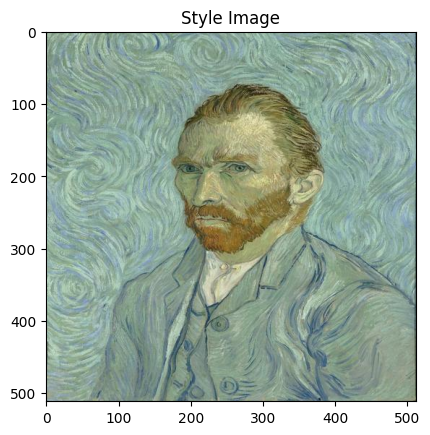

In [69]:
plt.figure()
imshow(style_img, title='Style Image')

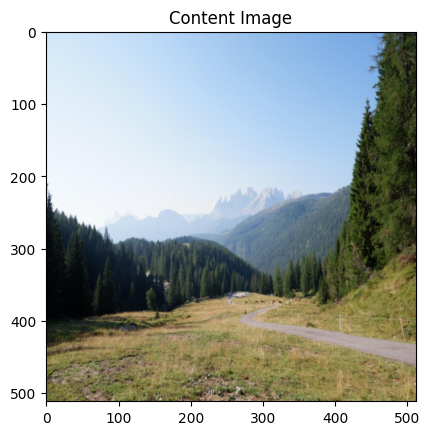

In [70]:
plt.figure()
imshow(content_img, title='Content Image')

### Content loss
The content loss measures the difference between the feature maps of the content image and the generated image. It ensures that the generated image retains the content of the original image.

The content loss module will be added after the convolution layer(s) that are being used to compute the content distance. 
This allows to compute the content loss after each convolution layer.

In [71]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

### Style loss: 
The style loss measures the difference between the feature maps of the style image and the generated image. It ensures that the generated image adopts the artistic style of the style image.

As for the content loss, the style loss is calculated after each convolution layer. To calculate the style loss we need to define the gram matrix.
A gram matrix is the result of multiplying a given matrix by its transposed matrix. The Gram matrix is used to measure the style of an image by computing the correlations between different feature maps extracted from a deep convolutional neural network.

In [72]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [73]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [74]:
# Import base model. We will use VGG19
cnn = models.vgg19(pretrained=True).features.eval()

Additionally, VGG networks are trained on images with each channel normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]. 
We will use them to normalize the image before sending it into the network.

In [75]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

# create a module to normalize input image so we can easily put it in a
# ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std

In [76]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

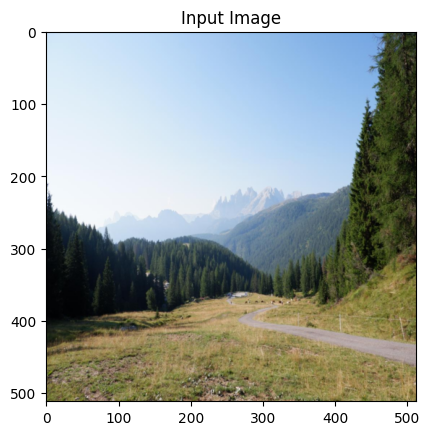

In [77]:
input_img = content_img.clone()
plt.figure()
imshow(input_img, title='Input Image')

In [78]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

For each iteration of the networks, it is fed an updated input and computes new losses. We will run the backward methods of each loss module to dynamically compute their gradients. The optimizer requires a “closure” function, which reevaluates the module and returns the loss.

In [79]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=600,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    # The network may try to optimize the input with values that exceed the 0 to 1 tensor range for the image. 
    # We can address this by correcting the input values to be between 0 to 1 each time the network is run.
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 49.497242 Content Loss: 7.972497

run [100]:
Style Loss : 9.204628 Content Loss: 7.732299

run [150]:
Style Loss : 3.048993 Content Loss: 6.115187

run [200]:
Style Loss : 1.843925 Content Loss: 4.940878

run [250]:
Style Loss : 1.310816 Content Loss: 4.354783

run [300]:
Style Loss : 0.906352 Content Loss: 4.021109

run [350]:
Style Loss : 0.634982 Content Loss: 3.767892

run [400]:
Style Loss : 0.501180 Content Loss: 3.597729

run [450]:
Style Loss : 0.440963 Content Loss: 3.485054

run [500]:
Style Loss : 0.408477 Content Loss: 3.414801

run [550]:
Style Loss : 0.384869 Content Loss: 3.365395

run [600]:
Style Loss : 0.368810 Content Loss: 3.331249



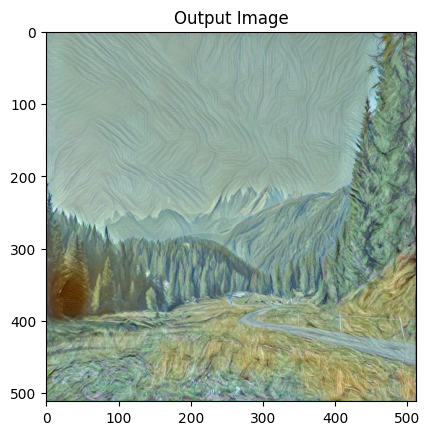

In [80]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

In [81]:
to_pil = transforms.ToPILImage()
image = to_pil(output.squeeze())

In [82]:
image.save(os.path.join(source_path, 'Data', 'transfered.jpg'))